In [1]:
import sys, platform
print(sys.executable)            # 应该包含 .../envs/qb/bin/python
print(platform.python_version()) # 3.11.x

import numpy as np, pandas as pd, yfinance as yf, sklearn, statsmodels, numba
print("All good ✅")

/opt/miniconda3/bin/python
3.13.1
All good ✅


,mean,vol,skew,kurt
Ticker,,,,
AAPL,0.2746,0.3159,-0.0870,6.4952
MSFT,0.2589,0.2888,-0.1894,7.9254
SPY,0.1573,0.2023,-0.5787,13.7832


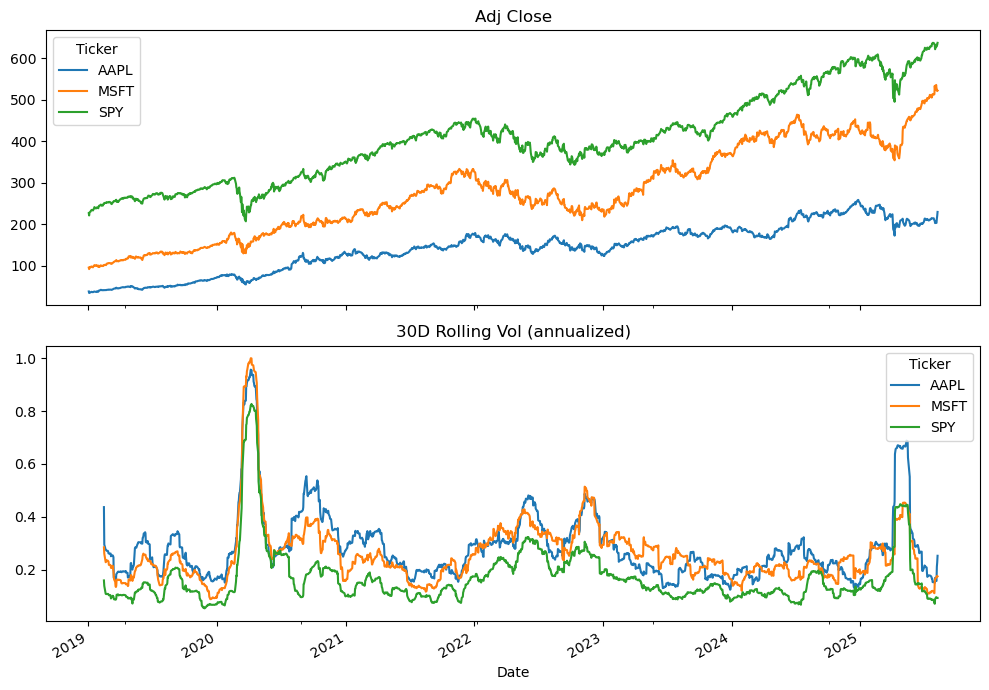

In [2]:
import pandas as pd, numpy as np, yfinance as yf
import matplotlib.pyplot as plt

tickers = ["AAPL","MSFT","SPY"]
df = yf.download(tickers, start="2019-01-01", auto_adjust=False, progress=False)

px = df["Adj Close"].dropna(how="all")
rets = np.log(px/px.shift(1)).dropna()

summary = pd.DataFrame({
    "mean": rets.mean()*252,
    "vol": rets.std()*np.sqrt(252),
    "skew": rets.skew(),
    "kurt": rets.kurt()
}).round(4)
display(summary)

fig, axes = plt.subplots(2,1, figsize=(10,7), sharex=True)
px.plot(ax=axes[0], title="Adj Close")
(rets.rolling(30).std()*np.sqrt(252)).plot(ax=axes[1], title="30D Rolling Vol (annualized)")
plt.tight_layout(); plt.show()

In [4]:
import pandas as pd
from bootcamp.week01.assignment.solution import log_returns, cumulative_returns

prices = pd.read_csv("bootcamp/week01/data/prices_stooq.csv",
                     index_col=0, parse_dates=True).sort_index()
spy = prices["SPY"]

rets = log_returns(spy.to_frame())["SPY"]   # 先把价格变成收益率
equity = cumulative_returns(rets)           # 把收益率累积成净值
equity.plot(title="SPY 累计净值曲线");      # 画图

ModuleNotFoundError: No module named 'bootcamp'

In [5]:
%cd ../..

/Users/mmm1441/quant-bootcamp


/opt/miniconda3/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20928 (\N{CJK UNIFIED IDEOGRAPH-51C0}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/opt/miniconda3/lib/python3.13/site-packages/IPython/core/ev

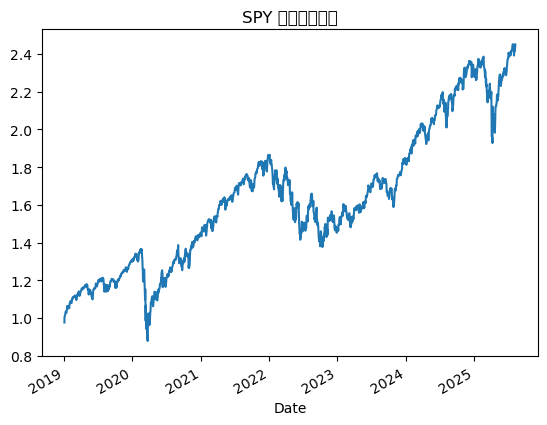

In [6]:
import pandas as pd
from bootcamp.week01.assignment.solution import log_returns, cumulative_returns

prices = pd.read_csv("bootcamp/week01/data/prices_stooq.csv",
                     index_col=0, parse_dates=True).sort_index()
spy = prices["SPY"]

rets = log_returns(spy.to_frame())["SPY"]
equity = cumulative_returns(rets)
equity.plot(title="SPY 累计净值曲线");

In [7]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

cjk_candidates = [
    "PingFang SC", "Hiragino Sans GB", "Heiti SC", "Songti SC",
    "STHeiti", "Microsoft YaHei", "SimHei",
    "Noto Sans CJK SC", "WenQuanYi Zen Hei", "Arial Unicode MS"
]
available = {f.name for f in fm.fontManager.ttflist}
for name in cjk_candidates:
    if name in available:
        plt.rcParams["font.family"] = name
        break
plt.rcParams["axes.unicode_minus"] = False  # 让负号正常显示

In [8]:
from bootcamp.week01.assignment.solution import log_returns, annualize_stats
rets = log_returns(spy.to_frame())["SPY"]  # 用刚才读到的 spy 价格序列
mu, vol = annualize_stats(rets)
print(f"年化收益: {mu:.2%}，年化波动: {vol:.2%}")

年化收益: 15.68%，年化波动: 20.23%


In [9]:
from bootcamp.week01.assignment.solution import sharpe_ratio
sr = sharpe_ratio(rets, rf=0.02)  # 假设无风险利率2%
print(f"夏普比: {sr:.2f}")

夏普比: 0.68


In [10]:
from bootcamp.week01.assignment.solution import cumulative_returns, max_drawdown
equity = cumulative_returns(rets)
dd = max_drawdown(equity)
print(f"最大回撤: {dd:.2%}")

最大回撤: -35.74%


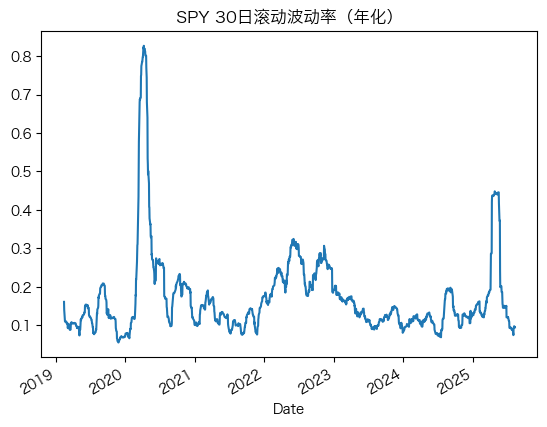

In [11]:
from bootcamp.week01.assignment.solution import rolling_vol
rv = rolling_vol(log_returns(spy.to_frame()), window=30)  # 30日窗口
rv["SPY"].plot(title="SPY 30日滚动波动率（年化）");

In [12]:
git add bootcamp/week01/week01-check.ipynb
git commit -m "Run week01 notebook: equity curve + metrics"
git push

SyntaxError: invalid syntax (1781528983.py, line 1)